# Imports

In [1]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## Define functions

In [2]:
def dark_theme(ax):
    """Set dark theme for plot to match website"""
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('#f8f8f2')
    ax.tick_params(axis='x', colors='#f8f8f2', which='both')
    ax.tick_params(axis='y', colors='#f8f8f2', which='both')
    ax.title.set_color('#f8f8f2')
    ax.set_facecolor('#272822')
    for axis in (ax.xaxis, ax.yaxis):
        axis.label.set_color('#f8f8f2')
    l = ax.legend()
    f = l.get_frame()
    f.set_facecolor('#272822')
    for text in l.get_texts():
        text.set_color("#f8f8f2")


def group_data(data_frame: pd.DataFrame, keys: List[str], extra_keys: List[str], grouper: str):
    """Group data, combining multiple programs"""
    grouped = data_frame[sorted(set(keys + extra_keys + [grouper, 'Trial']))].groupby([grouper, 'Trial']).sum().groupby(grouper)
    labels = sorted(set(data_frame[grouper]))
    return labels, grouped


def box_plot(data_frame: pd.DataFrame, keys: List[str], extra_keys: List[str], grouper: str, y_label: str):
    """Create boxplot"""
    grouped, labels = group_data(data_frame, keys, extra_keys, grouper)
    data = []
    for i in labels:
        g = grouped.get_group(i)
        data.append((sum(g[e] for e in keys)).values)

    fig1, ax1 = plt.subplots()
    plt.xlabel(grouper)
    plt.ylabel(y_label)
    plt.boxplot(data, labels=labels)
    return labels, grouped


def load_data(file_name: str, grouper: str):
    """Load and return parsed data"""
    loaded_data = pd.read_csv(file_name)
    keys = ['user', 'sys', 'Particle count', 'Beam count']
    if 'uss' in loaded_data:
        keys.append('uss')
    labels, grouped = group_data(loaded_data, ['user', 'sys'], keys, grouper)

    memory_mean = grouped.mean()['uss']
    cpu_mean = (grouped.mean()['user'] + grouped.mean()['sys'])
    return cpu_mean, memory_mean, labels

def regression_line(x: np.ndarray, y: np.ndarray, title: str, order: int = 1):
    """Scatter plot + regression line"""
    x = np.array(x)
    y = np.array(y)
    p = np.poly1d(np.polyfit(x, y, order))
    plt.scatter(x, y, label=title)
    reg_x = np.arange(x[0], x[-1], (x[-1] - x[0]) / 100)
    r2 = r2_score(y, p(x))
    plt.plot(reg_x, p(reg_x), '--',
             label=title + (" (order %d)" % order if order > 1 else " (linear)") + "  R² = %f" % r2)
    return r2

## Load data

In [3]:
quickmcl_double_int_cpu, quickmcl_double_int_memory, quickmcl_double_int_labels = load_data("data/quickmcl_double_int_laser.csv", "Particle count")

In [4]:
quickmcl_float_int_cpu, quickmcl_float_int_memory, quickmcl_float_int_labels = load_data("data/quickmcl_float_int_laser.csv", "Particle count")

In [5]:
quickmcl_float_ext_cpu, quickmcl_float_ext_memory, quickmcl_float_ext_labels = load_data("data/quickmcl_float_ext_laser.csv", "Particle count")

In [6]:
amcl_cpu, amcl_memory, amcl_labels = load_data("data/amcl.csv", "Particle count")

## Plot CPU usage

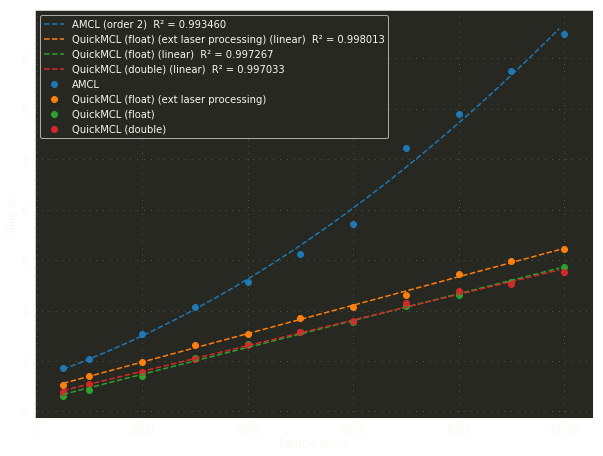

In [7]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(1, 1, 1)
plt.grid(dashes=[0.5,8])

regression_line(amcl_labels, amcl_cpu, "AMCL", 2)
regression_line(quickmcl_float_ext_labels, quickmcl_float_ext_cpu, "QuickMCL (float) (ext laser processing)", 1)
regression_line(quickmcl_float_int_labels, quickmcl_float_int_cpu, "QuickMCL (float)", 1)
regression_line(quickmcl_double_int_labels, quickmcl_double_int_cpu, "QuickMCL (double)", 1)
plt.xlabel("Particle count")
plt.ylabel("Time (s)")
plt.legend()
dark_theme(ax)
plt.savefig("amcl_vs_quickmcl_cpu.svg", transparent=True, bbox_inches='tight')

## Plot memory usage

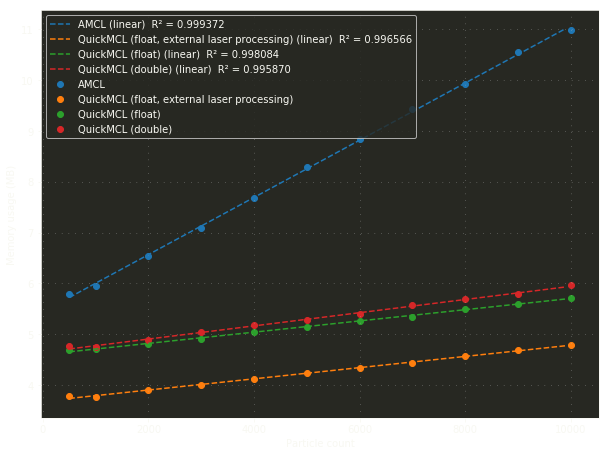

In [8]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(1, 1, 1)
plt.grid(dashes=[0.5,8])
to_mb = 1024 * 1024
regression_line(amcl_labels, amcl_memory / to_mb, "AMCL", 1)
regression_line(quickmcl_float_ext_labels, quickmcl_float_ext_memory / to_mb, "QuickMCL (float, external laser processing)", 1)
regression_line(quickmcl_float_int_labels, quickmcl_float_int_memory / to_mb, "QuickMCL (float)", 1)
regression_line(quickmcl_double_int_labels, quickmcl_double_int_memory / to_mb, "QuickMCL (double)", 1)
plt.xlabel("Particle count")
plt.ylabel("Memory usage (MB)")
dark_theme(ax)
plt.savefig("amcl_vs_quickmcl_memory.svg", transparent=True, bbox_inches='tight')